---
title: "Generative Adversarial Networks in PyTorch with PyTorch Lightning"
author: "Daniel J Smith"
date: "2024-04-30"
categories: [Python, ML, Deep Learning, PyTorch, GenAI]
title-block-banner: false
jupyter: python3
image: 'img/GANs.png'
draft: false
description: "A Generative Adversarial Network (GAN) is implemented in PyTorch with PyTorch Lightning to generate greyscale 64 x 64 images of items of clothing. Several refinements have been made to improve the quality of the generated images, such as the inclusion of batch normalisation layers in the generator, leaky-ReLU activation in the hidden layers of the discriminator and data augmentation via affine transformations and reflections."
---

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import pytorch_lightning as pl

from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST

import matplotlib.pyplot as plt
%matplotlib inline

import os 
from utils import *

BATCH_SIZE = 128
NUM_WORKERS=int(os.cpu_count() / 2)
versions()

+-------------------+------------+
|     Component     |  Version   |
+-------------------+------------+
|       Python      |   3.12.2   |
+-------------------+------------+
|      PyTorch      | 2.2.2+cpu  |
+-------------------+------------+
| PyTorch Lightning |   2.2.3    |
+-------------------+------------+
|    torchvision    | 0.17.2+cpu |
+-------------------+------------+


# Generative Adversarial Networks (GANs)

Generative Adversarial Networks (GANs) are a class of artificial intelligence algorithms used in unsupervised machine learning, implemented by a system of two neural networks contesting with each other in a zero-sum game framework. 
This technique was introduced by Ian Goodfellow and his colleagues in 2014 and has since been an active topic of research with applications including in generative image models, video generation, and voice generation systems.

GANs consist of two distinct models: a **generator** and a **discriminator**:

- **Generator**: This network learns to generate plausible data. The generated instances become negative training samples for the discriminator.
- **Discriminator**: This network learns to distinguish between real and fake data from the generator. The discriminator penalizes the generator for producing implausible results.

When training a GAN, the generator and discriminator are trained simultaneously:

1. **Generator Learning**: The generator improves its ability to create fake data by continuously attempting to deceive the discriminator. The optimal generator $G$ minimizes

    $$\log(1 - D(G(z)))$$

   where $G(z)$ is the generator's output when given noise $z$, and $D$ is the discriminator's estimate of the probability that a sample came from the training data rather than the generator.

2. **Discriminator Learning**: The discriminator improves its ability to distinguish real data from fake data produced by the generator. The optimal discrimator $D$ maximizes:

    $$\log D(x) + \log(1 - D(G(z)))$$

   where $x$ is data from the true distribution.

The training involves back-and-forth iterations where the discriminator guides the generator to produce more realistic outputs, and the generator forces the discriminator to become more skilled at distinguishing real data from fakes.

For a more comprehensive overview of GANs, refer to the original paper or additional resources on generative models:

> [Original GAN Paper by Ian Goodfellow et al., 2014](https://arxiv.org/abs/1406.2661)
>
> [Generative Models on OpenAI](https://openai.com/blog/generative-models/)


<img src="img/GANs.png" style="width:75%">

# PyTorch Lightning

> PyTorch Lightning is a library built on top of PyTorch that abstracts complexity so that researchers and developers can build models faster and more efficiently. By structuring PyTorch code to be more modular and hardware-agnostic, Lightning enables scalability across different hardware setups without changing the model code.
>
>PyTorch Lightning is designed for high flexibility and even higher performance, making it a popular choice for both academic researchers and industry practitioners.
>
>For more detailed information on PyTorch Lightning, visit the official documentation:
> 
>> [PyTorch Lightning Documentation](https://pytorch-lightning.readthedocs.io/en/latest/)

<br>

To install PyTorch Lightning using the `pip` package manager run
```cmd
pip install pytorch_lightning
```
at the command line.


# Fashion-MNIST Dataset

Fashion-MNIST is a dataset of Zalando's article images, designed as a more challenging replacement for the traditional MNIST dataset of handwritten digits. Each example in Fashion-MNIST is a 28x28 grayscale image, associated with a label from 10 classes. 

- **Number of Samples**: 70,000 (60,000 training and 10,000 test images)
- **Image Size**: 28x28 pixels, grayscale
- **Number of Classes**: 10

Each class corresponds to a type of clothing:
    
>    0. T-shirt/top
>    1. Trouser
>    2. Pullover
>    3. Dress
>    4. Coat
>    5. Sandal
>    6. Shirt
>    7. Sneaker
>    8. Bag
>    9. Ankle boot

In [2]:
#| code-fold: show

class FashionMNISTDataModule(pl.LightningDataModule):
    """
    PyTorch Lightning Data Module for the FashionMNIST dataset.
    Handles the loading, downloading, and transforming of data into train, validation, and test splits.
    """

    def __init__(self, data_dir="./data", batch_size=32, num_workers=4):
        """
        Initializes the data module.
        
        Args:
            data_dir (str): The directory to store/download the dataset.
            batch_size (int): Number of samples in each batch.
            num_workers (int): Number of subprocesses to use for data loading.
        """
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        # Define transformations that will be applied to each data sample
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Convert images to PyTorch tensors
            transforms.Normalize((0.5,), (0.5,)),  # Normalize grayscale images
        ])

    def prepare_data(self):
        """
        Download the FashionMNIST dataset if not already available locally.
        This method is only called from a single GPU.
        """
        FashionMNIST(self.data_dir, train=True, download=True)
        FashionMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        """
        Set up the dataset for the 'fit' and 'test' stages.
        
        Args:
            stage (str, optional): Stage for which the setup is being run. 
                                   If 'fit', set up for training and validation. 
                                   If 'test', set up for testing.
        """
        if stage == "fit" or stage is None:
            fashion_full = FashionMNIST(self.data_dir, train=True, transform=self.transform)
            # Randomly split the dataset into training and validation data
            self.fashion_train, self.fashion_val = random_split(fashion_full, [55000, 5000])

        if stage == "test" or stage is None:
            self.fashion_test = FashionMNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        """
        Returns:
            DataLoader: DataLoader for the training data.
        """
        return DataLoader(self.fashion_train, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)

    def val_dataloader(self):
        """
        Returns:
            DataLoader: DataLoader for the validation data.
        """
        return DataLoader(self.fashion_val, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)

    def test_dataloader(self):
        """
        Returns:
            DataLoader: DataLoader for the test data.
        """
        return DataLoader(self.fashion_test, batch_size=self.batch_size, num_workers=self.num_workers)


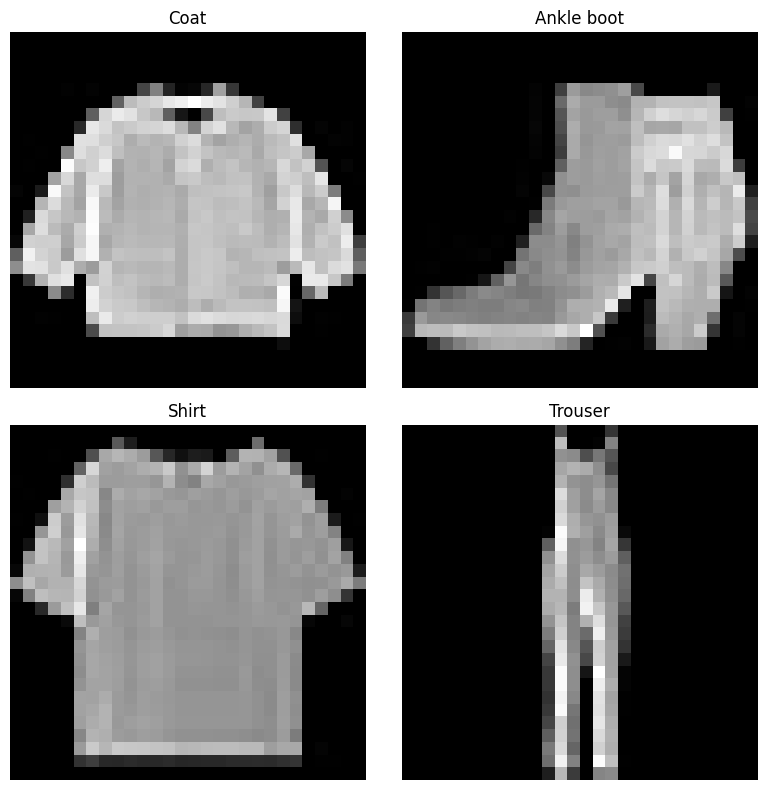

In [3]:
show_img()

# Generator Architecture

> The **Generator** is designed to map latent space vectors to the data space. It consists of a series of layers that progressively upsample the input vector to a higher resolution, culminating in an image of the desired size.
> 
> - **Input**: Receives a latent vector of dimensionality `latent_dim`.
> - **Layers**:
>   - A fully connected layer expands the latent vector into a 7x7x64 tensor.
>   - Two transposed convolutional layers (also known as deconvolutional layers) further upsample the tensor to larger spatial dimensions (14x14 and 28x28).
>   - Two batch normalisation layers, one after each convolutional layer.
>   - The final convolutional layer reduces the depth to produce a single-channel image, typically representing a grayscale image.

In [4]:
#| code-fold: show

class Generator(nn.Module):
    """
    Generator class for a GAN, producing images from a latent space input.
    """
    def __init__(self, latent_dim):
        """
        Initializes the Generator model.
        Args:
            latent_dim (int): Dimensionality of the latent space vector.
        """
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7 * 7 * 64)
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2)
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2)
        self.conv = nn.Conv2d(16, 1, kernel_size=7)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(32)

    def forward(self, x):
        """
        Forward pass through the Generator.
        Args:
            x (Tensor): Latent space input tensor.
        Returns:
            Tensor: Generated image tensor of shape [1, 28, 28].
        """
        x = F.relu(self.lin1(x))
        x = x.view(-1, 64, 7, 7)
        x = self.bn1(x)
        x = F.relu(self.ct1(x))
        x = self.bn2(x)
        x = F.relu(self.ct2(x))
        x = self.conv(x)
        return torch.tanh(x)


# Discriminator Architecture

> The **Discriminator** evaluates images, distinguishing between samples drawn from the training data and those generated by the generator. It is structured as a conventional convolutional neural network (CNN), which downsamples the input image to a scalar output that estimates the probability of the input being a real image.
> 
> - **Input**: Receives an image (real or generated).
> - **Layers**:
>   - Two convolutional layers with kernel size 5 for feature extraction, each followed by max pooling for spatial reduction.
>   - Dropout layer after the second convolutional layer to prevent overfitting.
>   - Two fully connected layers to output a probability score.

In [5]:
#| code-fold: show

class Discriminator(nn.Module):
    """
    Discriminator class for a GAN, distinguishing generated images from real images.
    """
    def __init__(self):
        """
        Initializes the Discriminator model.
        """
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        """
        Forward pass through the Discriminator.
        Args:
            x (Tensor): Input image tensor.
        Returns:
            Tensor: Probability tensor indicating the likelihood of the input being real.
        """
        x = F.leaky_relu(F.max_pool2d(self.conv1(x), 2), negative_slope=0.2)
        x = F.leaky_relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2), negative_slope=0.2)
        x = x.view(-1, 320)  # Flatten the output for the dense layer
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

# Combining into `GAN` Class

In [6]:
#| code-fold: show

class GAN(pl.LightningModule):
    """
    A GAN class inheriting from PyTorch Lightning Module for generating and discriminating images.
    """
    def __init__(self, latent_dim=100, lr=0.0002):
        """
        Initializes the GAN model.
        Args:
            latent_dim (int): Dimensionality of the latent space.
            lr (float): Learning rate for the optimizer.
        """
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False

        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()
        self.validation_z = torch.randn(6, self.hparams.latent_dim)  # Validation noise
        self.generator_losses = []
        self.discriminator_losses = []

    def forward(self, z):
        """
        Forward pass through the generator to create images from noise.
        Args:
            z (Tensor): A batch of random noise vectors.
        Returns:
            Tensor: Generated images.
        """
        return self.generator(z)

    def adversarial_loss(self, y_hat, y, is_real=True, is_discriminator=True, label_smoothing=0.1):
        """
        Computes the binary cross-entropy loss for adversarial training with label smoothing if required. 
        Args:
            y_hat (Tensor): Predicted probabilities.
            y (Tensor): True labels.
        Returns:
            Tensor: Loss value.
        """
        if is_discriminator and is_real:
            smoothed_labels = (1.0 - label_smoothing) * y
        else:
            smoothed_labels = y
        return F.binary_cross_entropy(y_hat, smoothed_labels)


    def training_step(self, batch, batch_idx):
        """
        Training logic for one epoch's step.
        Args:
            batch: The output of your DataLoader. A tuple (images, labels) in this case.
            batch_idx (int): Integer displaying index of this batch.
        Returns:
            Dictionary: Training loss and log metrics.
        """
        real_imgs, _ = batch
        d_loss = self._train_discriminator(real_imgs)
        g_loss = self._train_generator(real_imgs.size(0))
        self.generator_losses.append(g_loss.item())
        self.discriminator_losses.append(d_loss.item())
        self.log_dict({'g_loss': g_loss, 'd_loss': d_loss})
        return {'loss': d_loss, 'progress_bar': {'g_loss': g_loss, 'd_loss': d_loss}, 'log': {'g_loss': g_loss, 'd_loss': d_loss}}

    def plot_learning_curves(self):
        plt.figure(figsize=(10, 5))
        plt.title("Generator and Discriminator Loss During Training")
        plt.plot(self.generator_losses, label="Generator Loss")
        plt.plot(self.discriminator_losses, label="Discriminator Loss")
        plt.xlabel("Training Steps")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    def _train_generator(self, batch_size):
        """
        Handles the training of the generator.
        Args:
            batch_size (int): The size of the batch.
        Returns:
            Tensor: Generator loss.
        """
        z = self._generate_noise(batch_size)
        fake_imgs = self(z)
        y_hat = self.discriminator(fake_imgs)
        y = torch.ones(y_hat.shape, device=self.device)
        g_loss = self.adversarial_loss(y_hat, y)
        self.manual_backward(g_loss)
        self.optimizers()[0].step()
        self.optimizers()[0].zero_grad()
        return g_loss

    def _train_discriminator(self, real_imgs):
        """
        Handles the training of the discriminator.
        Args:
            real_imgs (Tensor): Real images from the dataset.
        Returns:
            Tensor: Discriminator loss.
        """
        # Train with real images
        y_hat_real = self.discriminator(real_imgs)
        y_real = torch.ones(y_hat_real.shape, device=self.device)
        real_loss = self.adversarial_loss(y_hat_real, y_real)

        # Train with fake images
        z = self._generate_noise(real_imgs.size(0))
        fake_imgs = self(z).detach()
        y_hat_fake = self.discriminator(fake_imgs)
        y_fake = torch.zeros(y_hat_fake.shape, device=self.device)
        fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

        # Average losses for the discriminator
        d_loss = (real_loss + fake_loss) / 2
        self.manual_backward(d_loss)
        self.optimizers()[1].step()
        self.optimizers()[1].zero_grad()
        return d_loss

    def validation_step(self, batch, batch_idx):
        # This is necessary if you have defined a validation dataloader
        pass


    def _generate_noise(self, batch_size):
        """
        Generates a tensor of random noise.
        Args:
            batch_size (int): The size of the batch.
        Returns:
            Tensor: A batch of random noise vectors.
        """
        return torch.randn(batch_size, self.hparams.latent_dim, device=self.device)

    def configure_optimizers(self):
        """
        Initializes and returns optimizers for generator and discriminator.
        Returns:
            List: List containing optimizers for generator and discriminator.
        """
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d], []

    def plot_imgs(self):
        """
        Plots generated images to visualize progress using matplotlib.
        """
        z = self.validation_z.to(self.generator.lin1.weight.device)
        with torch.no_grad():  # Ensures that gradients are not calculated in the forward pass
            sample_imgs = self(z).detach().cpu()  # Detach and move to CPU to avoid RuntimeError

        sample_imgs = (sample_imgs + 1) / 2
        print(f'Epoch: {self.current_epoch}')
        fig = plt.figure(figsize=(10, 6))
        for i in range(sample_imgs.size(0)):
            ax = fig.add_subplot(2, 3, i+1)
            ax.imshow(sample_imgs[i, 0, :, :], cmap='Greys_r')
            ax.axis('off')
        plt.show()


# Training

> During training, the generator and discriminator contest with each other:
>
> > The **Generator** aims to fool the discriminator by generating increasingly convincing images.
> > 
> > 
> >
> > The **Discriminator** strives to accurately classify real and generated images.
>
> The system is trained using a minimax game strategy, optimizing both networks concurrently to improve their accuracy and robustness. This adversarial setup helps improve the generative quality of the images as the training progresses.

The following code cell creates instances of the `FashionMNISTDataModule` and `GAN` classes and then trains the model on the training data, using the jupyter magic command `%%time` to track the time taken.

In [7]:
%%time

dm = FashionMNISTDataModule()
model = GAN(lr=5e-5)

trainer = pl.Trainer(
    max_epochs=50,
    check_val_every_n_epoch=1,  # Ensures validation happens and might trigger related hooks
    logger=True,
    enable_checkpointing=True,
)

trainer.fit(model, dm)

print('\nTraining Complete.\n')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
380 K     Trainable params
0         Non-trainable params
380 K     Total params
1.520     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.



Training Complete.

CPU times: total: 5h 35min 24s
Wall time: 57min 18s


Epoch: 50


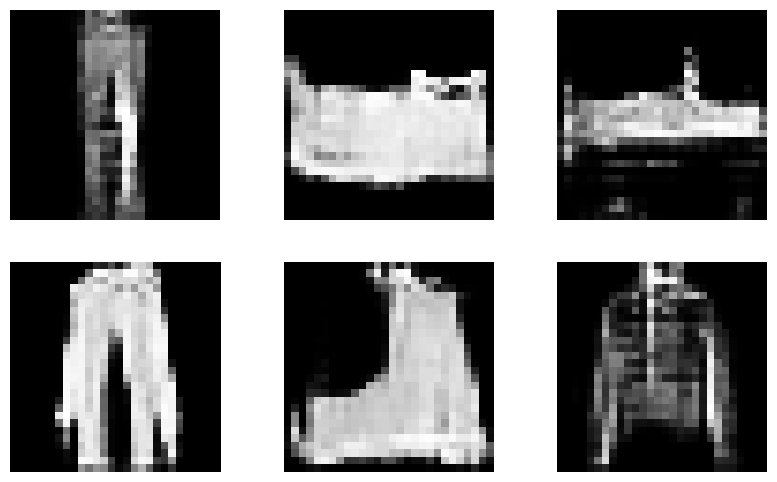

In [8]:
model.plot_imgs()

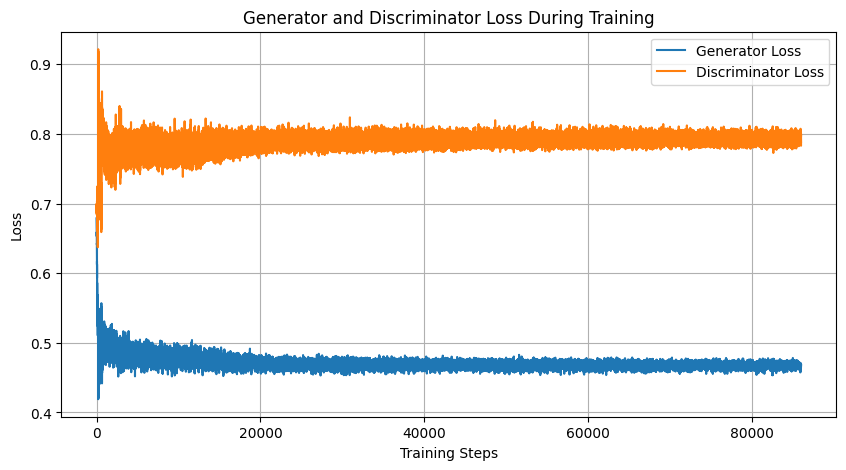

In [9]:
model.plot_learning_curves()